# Luderick Object Detection Using YOLOv5 (Training)

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [3]:
train_df = load_luderick_df('luderick_train_preprocessed.csv')
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')
test_df = load_luderick_df('luderick_test_preprocessed.csv')

train_df

,image_name,video_name,frame_number,number_boxes,labels,bounding_boxes,area,segmentation
0,04C1_Luderick_1.mov_5fps_000001.jpg,04C1_Luderick_1,1,1,[1],"[[1778, 425, 1919, 610]]",[26085],"[[1778, 515, 1789, 498, 1806, 479, 1835, 457, ..."
1,04C1_Luderick_1.mov_5fps_000002.jpg,04C1_Luderick_1,2,1,[1],"[[1659, 406, 1919, 645]]",[62140],"[[1659, 509, 1675, 488, 1696, 465, 1720, 437, ..."
2,04C1_Luderick_1.mov_5fps_000003.jpg,04C1_Luderick_1,3,1,[1],"[[1578, 400, 1915, 620]]",[74140],"[[1578, 530, 1585, 512, 1594, 496, 1592, 477, ..."
3,04C1_Luderick_1.mov_5fps_000004.jpg,04C1_Luderick_1,4,1,[1],"[[1508, 398, 1812, 626]]",[69312],"[[1812, 624, 1795, 578, 1795, 542, 1797, 507, ..."
4,04C1_Luderick_1.mov_5fps_000005.jpg,04C1_Luderick_1,5,1,[1],"[[1465, 390, 1699, 626]]",[55224],"[[1691, 591, 1687, 544, 1688, 503, 1691, 473, ..."
...,...,...,...,...,...,...,...,...
2667,C4_Luderick_9_014000.jpg,C4_Luderick_9,21,1,[1],"[[471, 127, 699, 360]]",[53124],"[[471, 360, 491, 319, 492, 280, 487, 236, 489,..."
2668,C4_Luderick_9_014200.jpg,C4_Luderick_9,22,1,[1],"[[561, 79, 829, 313]]",[62712],"[[578, 313, 592, 247, 618, 252, 656, 230, 679,..."
2669,C4_Luderick_9_014400.jpg,C4_Luderick_9,23,1,[1],"[[573, 33, 971, 261]]",[90744],"[[578, 261, 594, 213, 601, 183, 594, 146, 581,..."
2670,C4_Luderick_9_014600.jpg,C4_Luderick_9,24,1,[1],"[[650, 3, 1126, 216]]",[101388],"[[650, 216, 676, 182, 673, 133, 674, 90, 673, ..."


## Constants

In [4]:
sep = os.sep
DATASET_DIR = f"..{sep}datasets{sep}luderick"  # dataset root dir
IMAGES_DIR = os.path.join("Fish_automated_identification_and_counting", "luderick-seagrass")

# classes: 0 index is reserved for background
CLASSES = ['Luderick']
NUM_CLASSES = len(CLASSES)

# location to save model and plots
OUT_DIR = 'YOLOv5_outputs'
!mkdir {OUT_DIR}

Ya existe el subdirectorio o el archivo YOLOv5_outputs.


## Prepare the Dataset in the YOLO format

YOLO wants the following folder structure in the same folder of the yolov5 repository:


In [5]:
# datasets
#  │
#  └─ luderick
#     ├─ images
#     │   ├── train
#     │   │   ├── IMG_1.jpg
#     │   │   ...
#     │   │   └── IMG_X.jpg
#     │   │   
#     │   └── validation
#     │       ├── IMG_1.jpg
#     │       ...
#     │       └── IMG_X.jpg
#     │  
#     │
#     └── labels
#         ├── train
#         │   ├── IMG_1.txt
#         │   ...
#         │   └── IMG_X.txt
#         │   
#         └── validation
#             ├── IMG_1.txt
#             ...
#             └── IMG_X.txt

Annotation (labels) should have the following format:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

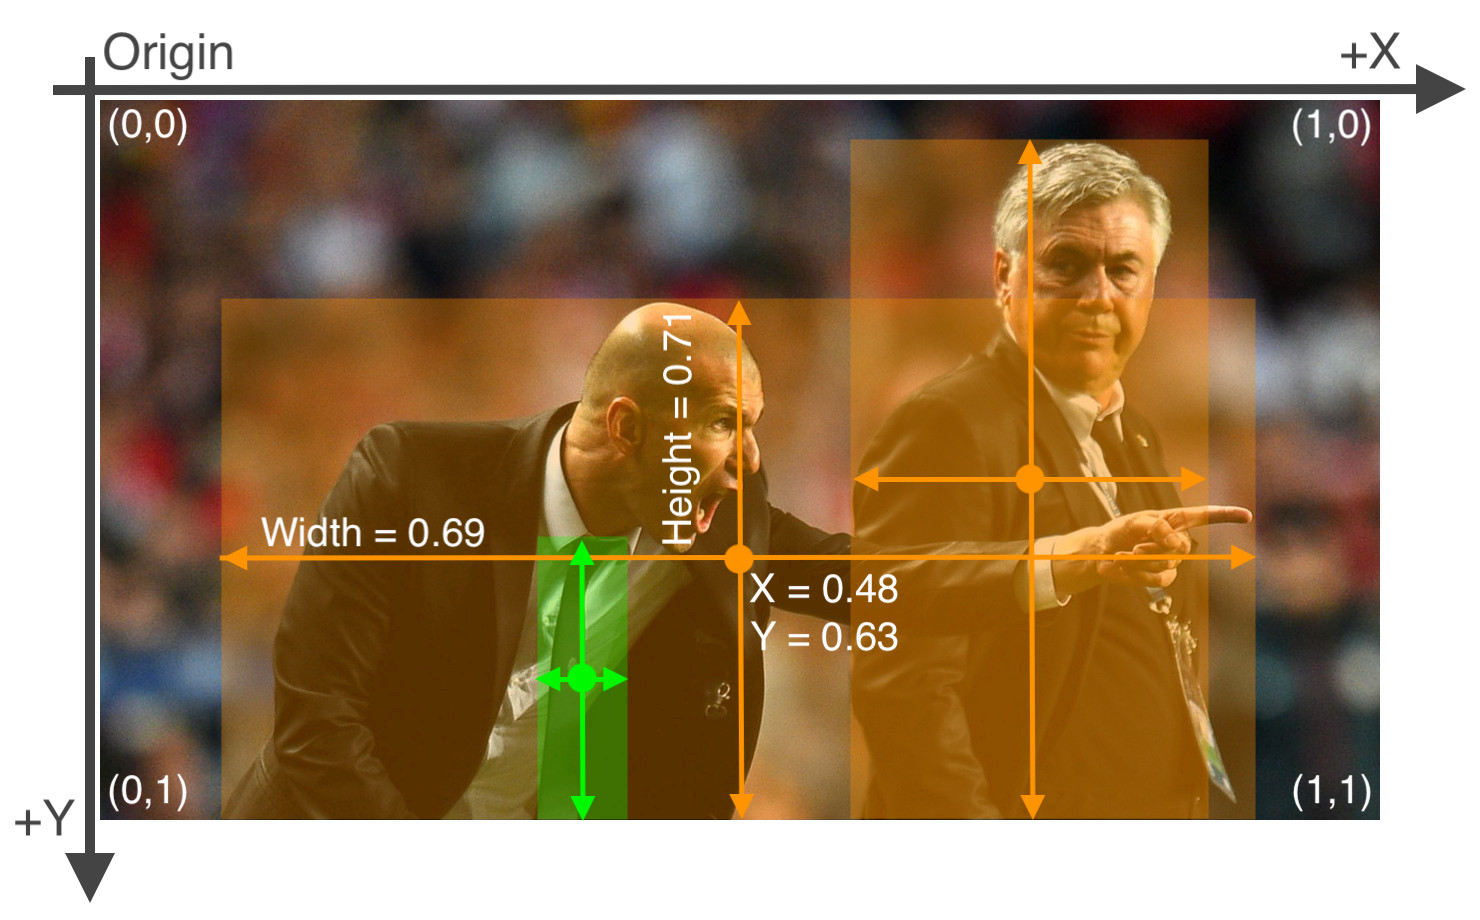

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

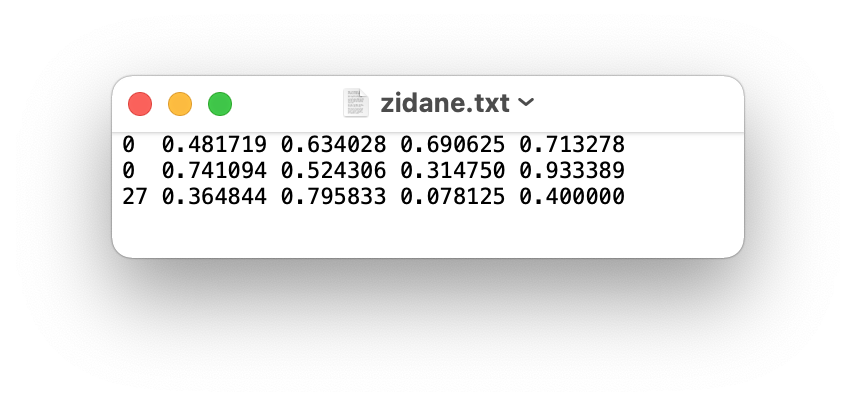

In [6]:
# Create folders

!mkdir datasets
%cd datasets
!mkdir luderick
%cd luderick
!mkdir images
!mkdir labels
%cd images
!mkdir train
!mkdir validation
!mkdir test
%cd ../labels
!mkdir train
!mkdir validation
!mkdir test
%cd ../../..

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick\images
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick\labels
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


In [7]:
# Copy images and create .txt annotations
def convert_to_yolo_dataset(luderick_df, images_dir, split_name):
    """
    Creates the yolo formatted labels from the luderick dataframe into datasets/luderick/labels/split_name
    and copies the images itno datasets/luderick/images/split_name
    """
    print("Starting dataset conversion...")
    sep = os.sep
    labels_out_path = f"datasets{sep}luderick{sep}labels{sep}{split_name}"
    img_out_path = f"datasets{sep}luderick{sep}images{sep}{split_name}"
    
    for index, row in luderick_df.iterrows():
        if index % (len(luderick_df)/4) == 0:
            print(f"{index/len(luderick_df)*100}% completed")
        image_path = os.path.join(images_dir, row['image_name'])
        image = Image.open(image_path).convert("RGB")
        # copy original image into yolo dataset path
        !copy {image_path} {img_out_path}
        
        width, height = image.size
        boxes = np.array(row['bounding_boxes'])
        labels = row['labels']
        image_name = row['image_name']
        # initialize the file
        # delete the .jpg from the image name
        label_file = open(f"{labels_out_path}{sep}{image_name[:-4]}.txt", 'a')
        for i, box in enumerate(boxes): 
            # get width and height
            box_width = box[2] - box[0]
            box_height = box[3] - box[1]
            # get the box center
            x_center = box[0] + (box_width / 2)
            y_center = box[1] + (box_height / 2)
            # normalize by dividing by image width and height
            x_center /= width
            box_width /= width
            y_center /= height
            box_height /= height
            # yolo class labels start from 0 and does not include the background
            class_label = labels[i] - 1 
            # create the yolo box line
            yolo_box = f"{class_label} {x_center} {y_center} {box_width} {box_height}"
            # add yolo box to a new line in the label file
            label_file.write(f'{yolo_box}\n')

        label_file.close()       

In [8]:
# convert each dataset split
convert_to_yolo_dataset(train_df, IMAGES_DIR, 'train')

Starting dataset conversion...
0.0% completed
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

In [9]:
convert_to_yolo_dataset(validation_df, IMAGES_DIR, 'validation')

Starting dataset conversion...
0.0% completed
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

In [10]:
convert_to_yolo_dataset(test_df, IMAGES_DIR, 'test')

Starting dataset conversion...
0.0% completed
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s

        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 archivo(s) copiado(s).
        1 

In [5]:
# visualize one annotation
with open("datasets/luderick/labels/train/04C1_Luderick_1.mov_5fps_000009.txt") as file:
    lines = file.readlines()
    print(lines)

['0 0.9377604166666667 0.49583333333333335 0.12135416666666667 0.25462962962962965\n', '0 0.7010416666666667 0.4930555555555556 0.07604166666666666 0.20092592592592592\n']


## Clone YOLOv5 repository and install dependencies

In [33]:
# clone yolov5
!git clone "https://github.com/ultralytics/yolov5"

Cloning into 'yolov5'...


In [35]:
# install dependencies
%cd yolov5
!pip install -r requirements.txt

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\yolov5
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.2.0-py3-none-any.whl (151 kB)
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


## Create dataset.yaml

In [37]:
yaml_text = \
"""# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/luderick  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/validation  # val images (relative to 'path') 128 images
test:  images/test # test images (optional)

# Classes
nc: 1  # number of classes
names: [ 'luderick' ]  # class names"""

with open("luderick.yaml", 'a') as file:
    file.write(yaml_text)

## Train YOLOv5

In [10]:
# Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/train

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20280), started 7:34:26 ago. (Use '!kill 20280' to kill it.)

Train a YOLOv5 model by specifying dataset, batch-size, image size and either pretrained --weights yolov5m.pt (recommended), or randomly initialized --weights '' --cfg yolov5s.yaml (not recommended). Pretrained weights are auto-downloaded from the latest YOLOv5 release.

In [7]:
%cd yolov5

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\yolov5


In [9]:
# Train YOLOv5m for 20 epochs, image resize to 640 and 4 batches
!python train.py --img 512 --batch 2 --epochs 20 --data luderick.yaml --weights yolov5m.pt --workers 1

train: weights=yolov5m.pt, cfg=, data=luderick.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=2, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v6.1-177-gd059d1d torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, tra

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## View result plots

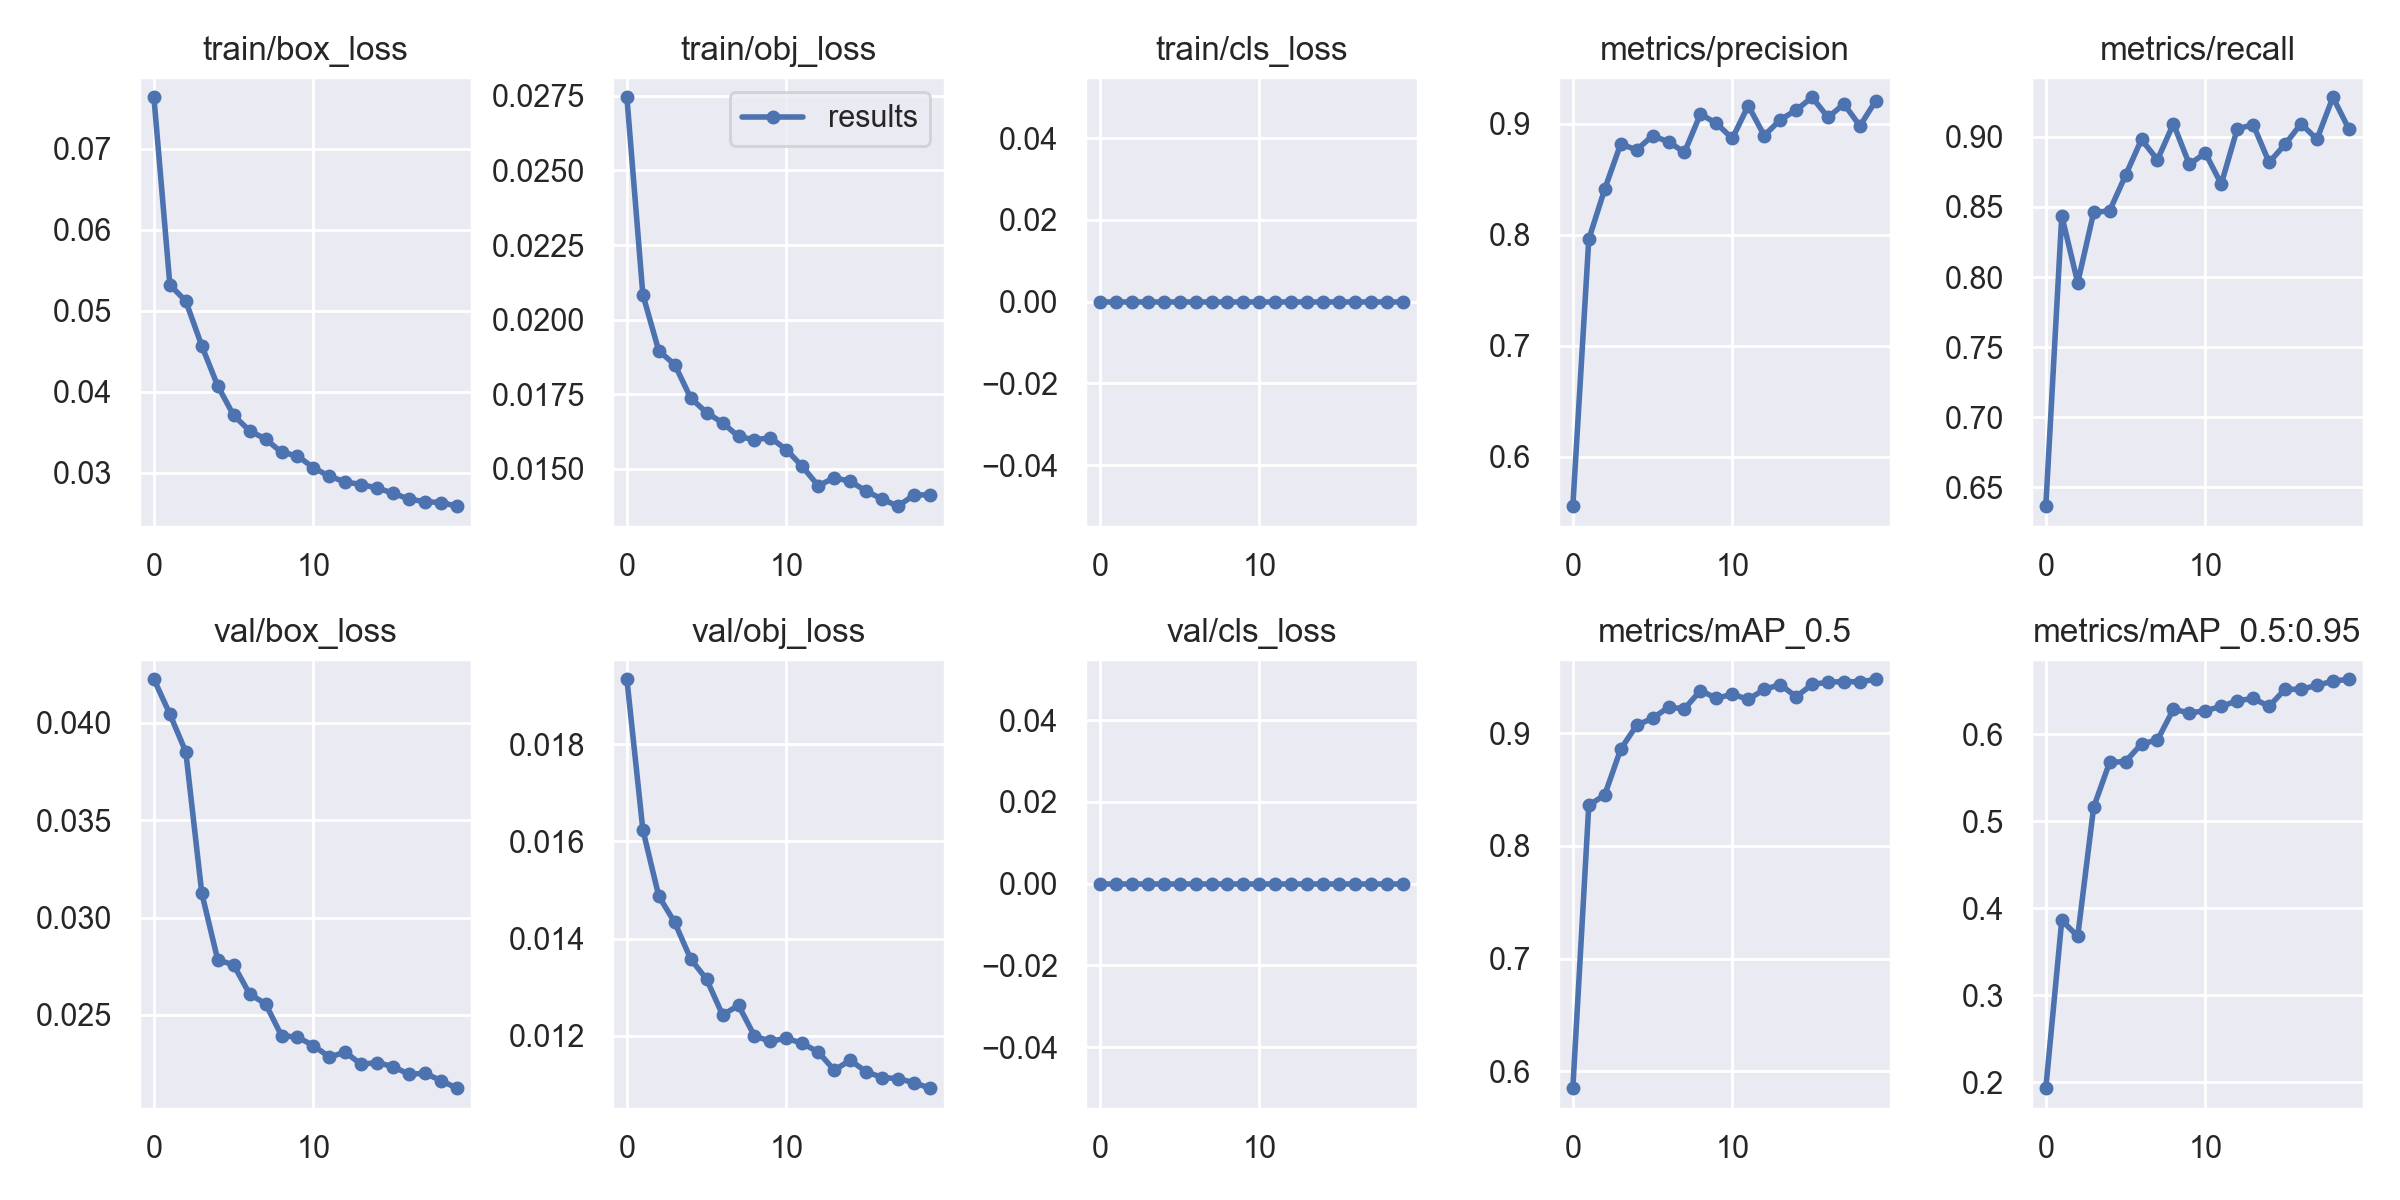

In [21]:
result_plots_img = Image.open(f"runs/train/exp/results.png")
display(result_plots_img)

## View a batch image (with mosaic data augmentation)

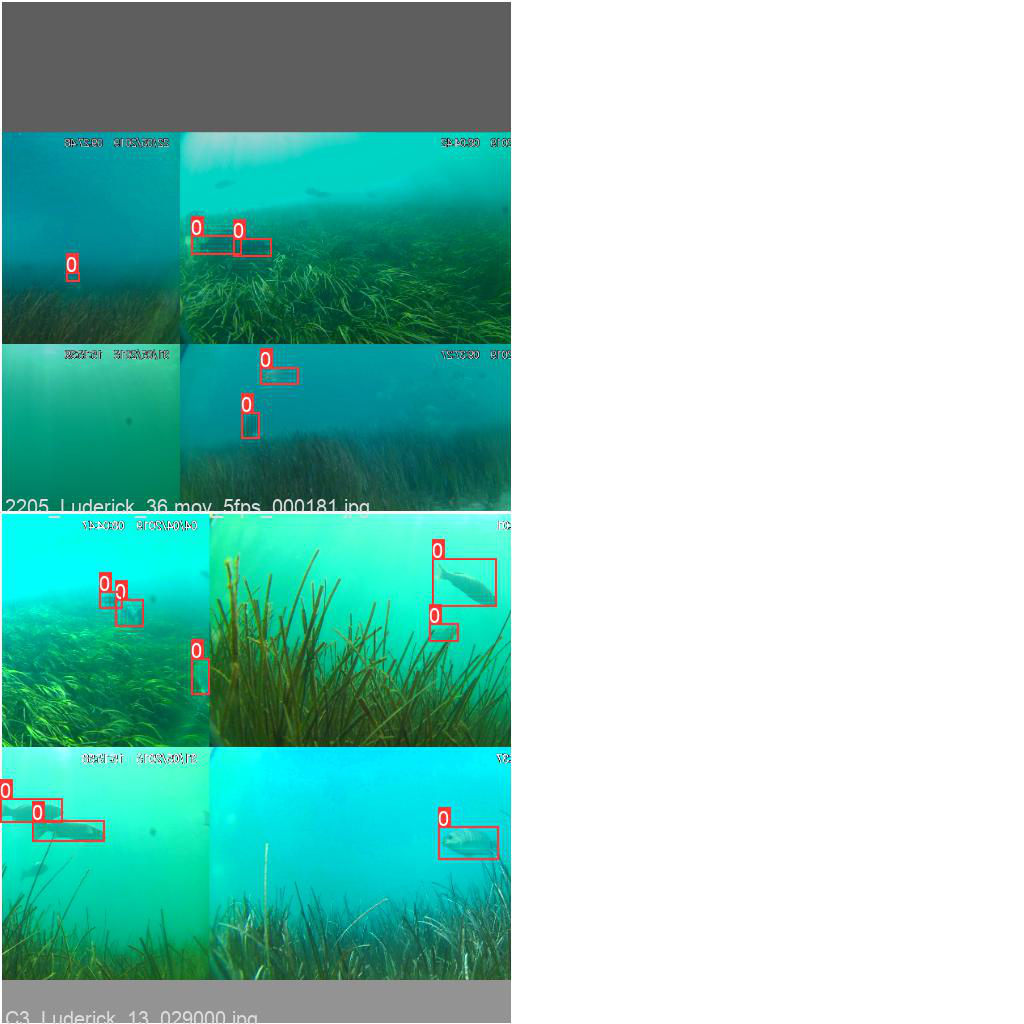

In [24]:
result_plots_img = Image.open(f"runs/train/exp/train_batch0.jpg")
display(result_plots_img)